# NBA - A case study between Player's Stats and Contracts

<img src="nbalogo.png" alt="Drawing" style="width: 1000px;"/>

<a id='toc'></a>

### Table of Contents
* [1. Pre-processing](#preprocessing)<br>
    * [1.1 Importing - Contract's Data](#contracts)<br>
    * [1.2 Importing - Players' Stats Data](#stats)<br>
    * [1.3 Merge Datasets](#merge)<br>
* [2. Data Exploration](#exploration)<br>
* [3. Regression analysis](#regression)<br>
* [4. Clustering](#cluster)<br>
    * [4.1 Data Scaling](#scaling)<br>
    * [4.2 Offensive Cluster](#offensive)<br>
    * [4.3 Defensive Cluster](#defensive)<br>
    * [4.4 Combine Clusters](#combine)<br>
    * [4.5 Clusters' Data Visualization](#viz)<br>




<a id='preprocessing'></a>

### 1. Pre-processing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

<a id='contracts'></a>

### 1.1 Importing - Contract's Data

<img src="espn.png" alt="Drawing" style="width: 500px;"/>

In [2]:
sal_21_22 = pd.read_csv('Player_Salaries/DB_Salaries_21_22.csv').set_index('Unnamed: 0')
sal_20_21 = pd.read_csv('Player_Salaries/DB_Salaries_20_21.csv').set_index('Unnamed: 0')
sal_19_20 = pd.read_csv('Player_Salaries/DB_Salaries_19_20.csv').set_index('Unnamed: 0')
sal_18_19 = pd.read_csv('Player_Salaries/DB_Salaries_18_19.csv').set_index('Unnamed: 0')

In [3]:
sal_21_22

,Player,Team,Annual Salary
Unnamed: 0,,,
0,"Stephen Curry, PG",Golden State Warriors,"$45,780,966"
1,"James Harden, SG",Philadelphia 76ers,"$44,310,840"
2,"John Wall, PG",Houston Rockets,"$44,310,840"
3,"Russell Westbrook, PG",Los Angeles Lakers,"$44,211,146"
4,"Kevin Durant, PF",Brooklyn Nets,"$42,018,900"
...,...,...,...
496,"Juwan Morgan, F",Toronto Raptors,"$19,816"
497,"Moses Brown, C",Cleveland Cavaliers,"$19,186"
498,"Xavier Sneed, F",Utah Jazz,"$8,558"


In [4]:
sal_21_22['Year'] = 2022
sal_20_21['Year'] = 2021
sal_19_20['Year'] = 2020
sal_18_19['Year'] = 2019

In [5]:
sal = pd.concat([sal_21_22, sal_20_21, sal_19_20, sal_18_19])
sal.reset_index()

,Unnamed: 0,Player,Team,Annual Salary,Year
0,0,"Stephen Curry, PG",Golden State Warriors,"$45,780,966",2022
1,1,"James Harden, SG",Philadelphia 76ers,"$44,310,840",2022
2,2,"John Wall, PG",Houston Rockets,"$44,310,840",2022
3,3,"Russell Westbrook, PG",Los Angeles Lakers,"$44,211,146",2022
4,4,"Kevin Durant, PF",Brooklyn Nets,"$42,018,900",2022
...,...,...,...,...,...
2091,498,"Jonathan Gibson, G",Boston Celtics,"$17,092",2019
2092,499,"Tarik Phillip, G",Washington Wizards,"$9,474",2019
2093,500,"Duncan Robinson, SG",Miami Heat,"$9,474",2019
2094,501,"Kendrick Nunn, G",Los Angeles Lakers,"$4,737",2019


In [6]:
sal[['Player','Position']] = sal.Player.str.rsplit(',', 1, expand = True,)

In [7]:
sal.drop(['Position'], axis = 1, inplace = True)

In [8]:
sal

,Player,Team,Annual Salary,Year
Unnamed: 0,,,,
0,Stephen Curry,Golden State Warriors,"$45,780,966",2022
1,James Harden,Philadelphia 76ers,"$44,310,840",2022
2,John Wall,Houston Rockets,"$44,310,840",2022
3,Russell Westbrook,Los Angeles Lakers,"$44,211,146",2022
4,Kevin Durant,Brooklyn Nets,"$42,018,900",2022
...,...,...,...,...
498,Jonathan Gibson,Boston Celtics,"$17,092",2019
499,Tarik Phillip,Washington Wizards,"$9,474",2019
500,Duncan Robinson,Miami Heat,"$9,474",2019


<a id='stats'></a>

### 1.2 - Importing - Players' Stats Data

<img src="bbr-logo.svg" alt="Drawing" style="width: 1000px;"/>

In [9]:
stats = pd.read_csv('Player_Stats/Player_Stats.csv')

In [10]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18885 entries, 0 to 18884
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18885 non-null  int64 
 1   Rk          18885 non-null  object
 2   Player      18885 non-null  object
 3   Pos         18885 non-null  object
 4   Age         18885 non-null  object
 5   Tm          18885 non-null  object
 6   G           18885 non-null  object
 7   GS          18885 non-null  object
 8   MP          18885 non-null  object
 9   FG          18885 non-null  object
 10  FGA         18885 non-null  object
 11  FG%         18779 non-null  object
 12  3P          18885 non-null  object
 13  3PA         18885 non-null  object
 14  3P%         16029 non-null  object
 15  2P          18885 non-null  object
 16  2PA         18885 non-null  object
 17  2P%         18709 non-null  object
 18  eFG%        18779 non-null  object
 19  FT          18885 non-null  object
 20  FTA   

In [11]:
stats_new = stats[stats['Year'].isin([2019, 2020, 2021, 2022])]

In [12]:
import unidecode
lst = []

for i in stats_new['Player']:
    temp = unidecode.unidecode(i)
    lst.append(temp)

We used the unicode package so we could remove accent marks from players' names.

In [13]:
stats_new['Player_uni'] = lst

/var/folders/hs/t_th7f6j6tsb1fg2d7_808y80000gn/T/ipykernel_4920/535091382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_new['Player_uni'] = lst


In [14]:
stats_new

,Unnamed: 0,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni
15905,0,1,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,...,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,Alex Abrines
15906,1,2,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,...,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7,2019,Quincy Acy
15907,2,3,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,...,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2,2019,Jaylen Adams
15908,3,4,Steven Adams,C,25,OKC,80,80,33.4,6.0,...,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9,2019,Steven Adams
15909,4,5,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,...,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9,2019,Bam Adebayo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18880,836,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,...,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3,2022,Thaddeus Young
18881,837,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,...,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,2022,Trae Young
18882,838,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,...,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3,2022,Omer Yurtseven
18883,839,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,...,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2,2022,Cody Zeller


In [15]:
stats_new.reset_index(inplace = True)

In [16]:
stats_new.drop(columns = ['index', 'Unnamed: 0'], inplace = True)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
stats_new

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni
0,1,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,...,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,Alex Abrines
1,2,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,...,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7,2019,Quincy Acy
2,3,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,...,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2,2019,Jaylen Adams
3,4,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,...,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9,2019,Steven Adams
4,5,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,...,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9,2019,Bam Adebayo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,...,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3,2022,Thaddeus Young
2976,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,...,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,2022,Trae Young
2977,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3,2022,Omer Yurtseven
2978,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2,2022,Cody Zeller


<a id='merge'></a>

### 1.3 Merge Datasets

In [18]:
df = stats_new.merge(sal, how = 'left', left_on = ['Player_uni', 'Year'], right_on = ['Player', 'Year'])

In [19]:
df.drop('Team', axis = 1, inplace = True)

In [20]:
df

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni,Player_y,Annual Salary
0,1,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.6,0.5,0.2,0.5,1.7,5.3,2019,Alex Abrines,Alex Abrines,"$5,455,236"
1,2,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.8,0.1,0.4,0.4,2.4,1.7,2019,Quincy Acy,NaN,NaN
2,3,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,...,1.9,0.4,0.1,0.8,1.3,3.2,2019,Jaylen Adams,Jaylen Adams,"$270,014"
3,4,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,...,1.6,1.5,1.0,1.7,2.6,13.9,2019,Steven Adams,Steven Adams,"$24,157,303"
4,5,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,...,2.2,0.9,0.8,1.5,2.5,8.9,2019,Bam Adebayo,Bam Adebayo,"$2,955,840"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2978,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,...,1.7,1.2,0.4,0.8,1.7,6.3,2022,Thaddeus Young,Thaddeus Young,"$14,190,000"
2979,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,...,9.7,0.9,0.1,4.0,1.7,28.4,2022,Trae Young,Trae Young,"$8,326,471"
2980,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,0.9,0.3,0.4,0.7,1.5,5.3,2022,Omer Yurtseven,Omer Yurtseven,"$1,489,065"
2981,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.8,0.3,0.2,0.7,2.1,5.2,2022,Cody Zeller,NaN,NaN


In [21]:
df[df['Annual Salary'].isna()]['G'].value_counts()

G     104
1      50
2      48
3      43
4      37
5      24
10     22
6      18
7      17
13     17
11     17
9      14
19     13
18     10
8      10
14      9
12      7
22      7
15      6
26      6
23      5
31      5
16      5
33      4
21      4
17      4
30      4
24      4
28      4
32      4
20      4
25      3
42      3
38      3
50      3
41      3
37      3
36      3
53      2
34      2
29      2
27      2
60      2
75      2
44      2
48      2
40      2
43      2
54      1
52      1
59      1
51      1
57      1
65      1
64      1
62      1
46      1
76      1
58      1
61      1
Name: G, dtype: int64

In [22]:
df.drop(df[df['G'] == 'G'].index, inplace = True)

Removing the header rows extracted from Basketball Reference website

In [23]:
df[df['G'] == 'G']

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni,Player_y,Annual Salary


In [24]:
df[df['Annual Salary'].isna()]

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni,Player_y,Annual Salary
1,2,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.8,0.1,0.4,0.4,2.4,1.7,2019,Quincy Acy,NaN,NaN
5,6,Deng Adel,SF,21,CLE,19,3,10.2,0.6,1.9,...,0.3,0.1,0.2,0.3,0.7,1.7,2019,Deng Adel,NaN,NaN
6,7,DeVaughn Akoon-Purcell,SG,25,DEN,7,0,3.1,0.4,1.4,...,0.9,0.3,0.0,0.3,0.6,1.0,2019,DeVaughn Akoon-Purcell,NaN,NaN
8,9,Rawle Alkins,SG,21,CHI,10,1,12.0,1.3,3.9,...,1.3,0.1,0.0,0.8,0.7,3.7,2019,Rawle Alkins,NaN,NaN
11,12,Kadeem Allen,PG,26,NYK,19,1,21.9,3.4,7.4,...,4.0,0.8,0.2,1.4,2.4,9.9,2019,Kadeem Allen,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,599,Moses Wright,PF,23,TOT,4,0,3.5,0.3,1.0,...,0.5,0.0,0.3,0.0,0.0,1.3,2022,Moses Wright,NaN,NaN
2972,599,Moses Wright,PF,23,LAC,1,0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2022,Moses Wright,NaN,NaN
2973,599,Moses Wright,PF,23,DAL,3,0,4.3,0.3,1.3,...,0.3,0.0,0.3,0.0,0.0,1.7,2022,Moses Wright,NaN,NaN
2974,600,Gabe York,SG,28,IND,2,0,10.5,1.0,3.5,...,2.0,1.0,0.5,0.5,2.0,4.0,2022,Gabe York,NaN,NaN


In [25]:
df_19 = df[(df['Year'] == 2019)]
df_19.drop(df_19[df_19['Player_uni'].duplicated()].index, inplace = True)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
df_19[df_19['Player_uni'].duplicated()]

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni,Player_y,Annual Salary


In [27]:
df_20 = df[(df['Year'] == 2020)]
df_20.drop(df_20[df_20['Player_uni'].duplicated()].index, inplace = True)

df_21 = df[(df['Year'] == 2021)]
df_21.drop(df_21[df_21['Player_uni'].duplicated()].index, inplace = True)

df_22 = df[(df['Year'] == 2022)]
df_22.drop(df_22[df_22['Player_uni'].duplicated()].index, inplace = True)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [28]:
df_22[df_22['Player_uni'].duplicated()]

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni,Player_y,Annual Salary


Players there were traded have multiple stat entries in the tables. We used the code above to remove the duplicate entries of such players leaving only the rows containing their total stats per each season.

In [29]:
stat = pd.concat([df_19, df_20, df_21, df_22])

In [30]:
stat['G'] = stat['G'].astype(int)
stat['PTS'] = stat['PTS'].astype(float)

In [31]:
stat[stat['Player_uni'] == 'Kevin Durant']

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni,Player_y,Annual Salary
197,150,Kevin Durant,SF,30,GSW,78,78,34.6,9.2,17.7,...,5.9,0.7,1.1,2.9,2.0,26.0,2019,Kevin Durant,Kevin Durant,"$30,000,000"
1597,140,Kevin Durant,PF,32,BRK,35,32,33.1,9.3,17.2,...,5.6,0.7,1.3,3.4,2.0,26.9,2021,Kevin Durant,Kevin Durant,"$40,108,950"
2346,154,Kevin Durant,PF,33,BRK,55,55,37.2,10.5,20.3,...,6.4,0.9,0.9,3.5,2.1,29.9,2022,Kevin Durant,Kevin Durant,"$42,018,900"


In [32]:
stat

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni,Player_y,Annual Salary
0,1,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.6,0.5,0.2,0.5,1.7,5.3,2019,Alex Abrines,Alex Abrines,"$5,455,236"
1,2,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.8,0.1,0.4,0.4,2.4,1.7,2019,Quincy Acy,NaN,NaN
2,3,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,...,1.9,0.4,0.1,0.8,1.3,3.2,2019,Jaylen Adams,Jaylen Adams,"$270,014"
3,4,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,...,1.6,1.5,1.0,1.7,2.6,13.9,2019,Steven Adams,Steven Adams,"$24,157,303"
4,5,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,...,2.2,0.9,0.8,1.5,2.5,8.9,2019,Bam Adebayo,Bam Adebayo,"$2,955,840"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,601,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,...,2.0,1.0,0.3,1.0,1.6,6.2,2022,Thaddeus Young,Thaddeus Young,"$14,190,000"
2979,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,...,9.7,0.9,0.1,4.0,1.7,28.4,2022,Trae Young,Trae Young,"$8,326,471"
2980,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,0.9,0.3,0.4,0.7,1.5,5.3,2022,Omer Yurtseven,Omer Yurtseven,"$1,489,065"
2981,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.8,0.3,0.2,0.7,2.1,5.2,2022,Cody Zeller,NaN,NaN


In [33]:
stat.drop(stat[(stat['Annual Salary'].isna()) & (stat['G'] <= 16)].index, inplace = True) 

We decided to drop players that have played less than 20 % of the games, because we don't believe such players give a good representation of the influence that per game statistics have on contracts.

In [34]:
stat[(stat['Annual Salary'].isna()) & (stat['PTS'] >= 10)]

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Year,Player_uni,Player_y,Annual Salary
388,285,Kevin Knox,PF,19,NYK,75,57,28.8,4.5,12.2,...,1.1,0.6,0.3,1.5,2.3,12.8,2019,Kevin Knox,NaN,NaN
498,361,Marcus Morris,PF,29,BOS,75,53,27.9,5.0,11.3,...,1.5,0.6,0.3,1.2,2.4,13.9,2019,Marcus Morris,NaN,NaN
575,418,J.J. Redick,SG,34,PHI,76,63,31.3,5.9,13.5,...,2.7,0.4,0.2,1.3,1.7,18.1,2019,J.J. Redick,NaN,NaN
1182,351,Marcus Morris,SF-PF,30,TOT,62,62,31.2,5.7,13.1,...,1.4,0.8,0.5,1.6,2.9,16.7,2020,Marcus Morris,NaN,NaN
1263,419,J.J. Redick,SG,35,NOP,60,36,26.4,4.8,10.5,...,2.0,0.3,0.2,1.3,1.6,15.3,2020,J.J. Redick,NaN,NaN
1501,70,Armoni Brooks,SG,22,HOU,20,5,26.0,3.9,9.6,...,1.5,0.6,0.3,1.1,1.7,11.2,2021,Armoni Brooks,NaN,NaN
1884,354,Marcus Morris,PF,31,LAC,57,29,26.4,4.8,10.2,...,1.0,0.6,0.3,1.0,2.1,13.4,2021,Marcus Morris,NaN,NaN
2691,393,Marcus Morris,PF,32,LAC,54,54,29.0,5.6,12.8,...,2.1,0.5,0.3,1.3,2.1,15.4,2022,Marcus Morris,NaN,NaN
2954,584,Brandon Williams,PG,22,POR,24,16,26.7,4.4,11.8,...,3.9,1.0,0.4,2.4,2.2,12.9,2022,Brandon Williams,NaN,NaN
2959,589,Robert Williams,C,24,BOS,61,61,29.6,4.4,6.0,...,2.0,0.9,2.2,1.0,2.2,10.0,2022,Robert Williams,NaN,NaN


In [35]:
stat['Annual Salary'][(stat['Player_uni'] == 'J.J. Redick') & (stat['Year'] == 2019)] = '$12,500,000'

/var/folders/hs/t_th7f6j6tsb1fg2d7_808y80000gn/T/ipykernel_4920/2323222924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['Annual Salary'][(stat['Player_uni'] == 'J.J. Redick') & (stat['Year'] == 2019)] = '$12,500,000'


In [36]:
stat['Annual Salary'][(stat['Player_uni'] == 'J.J. Redick') & (stat['Year'] == 2020)] = '$13,486,300'
stat['Annual Salary'][(stat['Player_uni'] == 'Marcus Morris') & (stat['Year'] == 2019)] = '$15,000,000'
stat['Annual Salary'][(stat['Player_uni'] == 'Marcus Morris') & (stat['Year'] == 2020)] = '$15,000,000'
stat['Annual Salary'][(stat['Player_uni'] == 'Marcus Morris') & (stat['Year'] == 2021)] = '$14,883,721'
stat['Annual Salary'][(stat['Player_uni'] == 'Marcus Morris') & (stat['Year'] == 2022)] = '$15,627,907'
stat['Annual Salary'][(stat['Player_uni'] == 'Kevin Knox') & (stat['Year'] == 2019)] = '$3,739,920'
stat['Annual Salary'][(stat['Player_uni'] == 'Robert Williams') & (stat['Year'] == 2022)] = '$3,661,976'

/var/folders/hs/t_th7f6j6tsb1fg2d7_808y80000gn/T/ipykernel_4920/1939007534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['Annual Salary'][(stat['Player_uni'] == 'J.J. Redick') & (stat['Year'] == 2020)] = '$13,486,300'
/var/folders/hs/t_th7f6j6tsb1fg2d7_808y80000gn/T/ipykernel_4920/1939007534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['Annual Salary'][(stat['Player_uni'] == 'Marcus Morris') & (stat['Year'] == 2019)] = '$15,000,000'
/var/folders/hs/t_th7f6j6tsb1fg2d7_808y80000gn/T/ipykernel_4920/1939007534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

We manualy imputed annual salaries for players that had 12 pts or higher because it was detected that when merging both datasets, the name was different (Sr. or JJ being different between both websites)

In [37]:
stat.drop(columns = ['Player_uni', 'Player_y'], inplace = True)

In [38]:
stat[stat['Annual Salary'].isna()]

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Annual Salary
5,6,Deng Adel,SF,21,CLE,19,3,10.2,0.6,1.9,...,0.8,1.0,0.3,0.1,0.2,0.3,0.7,1.7,2019,NaN
11,12,Kadeem Allen,PG,26,NYK,19,1,21.9,3.4,7.4,...,2.3,2.7,4.0,0.8,0.2,1.4,2.4,9.9,2019,NaN
63,55,Jaron Blossomgame,SF,25,CLE,27,4,16.3,1.7,3.9,...,2.7,3.6,0.5,0.3,0.3,0.4,0.7,4.2,2019,NaN
88,75,Lorenzo Brown,PG,28,TOR,26,0,8.2,0.9,2.7,...,1.0,1.2,1.1,0.5,0.2,0.6,0.8,2.1,2019,NaN
123,95,Alex Caruso,PG,24,LAL,25,4,21.2,3.1,6.9,...,1.9,2.7,3.1,1.0,0.4,1.7,2.2,9.2,2019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,571,Lindy Waters III,SG,24,OKC,25,1,18.6,2.8,7.0,...,2.7,2.9,1.0,0.8,0.3,0.4,1.2,8.0,2022,NaN
2951,581,Aaron Wiggins,SG,23,OKC,50,35,24.2,3.1,6.7,...,2.5,3.6,1.4,0.6,0.2,1.1,1.9,8.3,2022,NaN
2953,583,Lindell Wigginton,PG,23,MIL,19,0,10.5,1.4,3.2,...,1.2,1.3,1.2,0.3,0.1,0.6,0.9,4.2,2022,NaN
2954,584,Brandon Williams,PG,22,POR,24,16,26.7,4.4,11.8,...,2.3,3.1,3.9,1.0,0.4,2.4,2.2,12.9,2022,NaN


In [39]:
stat.drop(stat[stat['Annual Salary'].isna()].index, inplace = True)

In [40]:
stat

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Annual Salary
0,1,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,...,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,"$5,455,236"
2,3,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,...,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2,2019,"$270,014"
3,4,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,...,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9,2019,"$24,157,303"
4,5,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,...,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9,2019,"$2,955,840"
7,8,LaMarcus Aldridge,C,33,SAS,81,81,33.2,8.4,16.3,...,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3,2019,"$22,347,015"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,597,Delon Wright,SG,29,ATL,77,8,18.9,1.6,3.5,...,2.2,2.9,2.4,1.2,0.2,0.6,0.7,4.4,2022,"$8,526,316"
2976,601,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,...,2.5,4.0,2.0,1.0,0.3,1.0,1.6,6.2,2022,"$14,190,000"
2979,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,...,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,2022,"$8,326,471"
2980,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3,2022,"$1,489,065"


In [41]:
stat['Pos'].value_counts() # count per position
stat[stat['Pos']=='SG-SF']

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Annual Salary
621,450,Jonathon Simmons,SG-SF,29,TOT,56,9,19.0,2.4,6.3,...,1.8,2.3,2.3,0.5,0.3,1.2,1.6,6.5,2019,"$6,000,000"
885,115,Allen Crabbe,SG-SF,27,TOT,37,1,17.6,1.7,4.8,...,1.8,2.1,0.9,0.4,0.1,0.5,1.3,4.6,2020,"$18,500,000"
1577,126,Hamidou Diallo,SG-SF,22,TOT,52,9,23.6,4.3,9.0,...,4.1,5.2,1.9,0.8,0.5,1.5,2.6,11.6,2021,"$1,663,861"
1962,415,Norman Powell,SG-SF,27,TOT,69,58,32.0,6.3,13.3,...,2.5,3.1,1.9,1.2,0.3,1.7,2.3,18.6,2021,"$10,865,952"
2446,226,Josh Hart,SG-SF,26,TOT,54,53,33.2,5.3,10.5,...,6.0,7.2,4.1,1.1,0.2,2.1,2.8,14.9,2022,"$12,000,000"
2496,257,Elijah Hughes,SG-SF,23,TOT,36,4,12.1,1.3,4.0,...,1.4,1.6,0.6,0.4,0.2,0.5,1.1,3.5,2022,"$1,517,981"
2615,338,Didi Louzada,SG-SF,22,TOT,9,1,14.3,1.3,3.7,...,1.3,1.9,0.6,0.2,0.2,0.6,1.4,3.9,2022,"$1,786,878"
2864,518,Lance Stephenson,SG-SF,31,TOT,46,1,17.7,3.2,7.0,...,2.5,2.8,3.6,0.5,0.1,1.6,2.1,8.3,2022,"$642,729"


In [42]:
stat['Annual Salary'] = stat['Annual Salary'].apply(lambda x: x.replace(',',''))
stat['Annual Salary'] = stat['Annual Salary'].apply(lambda x: x.replace('$',''))

In [43]:
stat.loc[stat['Pos'].isin(['PG', 'SG', 'PG-SG', 'SG-PG', 'SG-SF', 'SG-PF']), 'Pos'] = 'Guard'
stat.loc[stat['Pos'].isin(['PF', 'SF', 'SF-SG', 'PF-SF', 'PF-C', 'SF-PF', 'SF-C']), 'Pos'] = 'Forward'
stat.loc[stat['Pos'].isin(['C', 'C-PF']), 'Pos'] = 'Center'
stat['Pos'].value_counts()

Guard      751
Forward    719
Center     363
Name: Pos, dtype: int64

We decided to divide the players' positions into macro positions: Guard, Forward and Center

<a id='exploration'></a>

### 2. Data Exploration

In [44]:
stat.dtypes

Rk                object
Player_x          object
Pos               object
Age               object
Tm                object
G                  int64
GS                object
MP                object
FG                object
FGA               object
FG%               object
3P                object
3PA               object
3P%               object
2P                object
2PA               object
2P%               object
eFG%              object
FT                object
FTA               object
FT%               object
ORB               object
DRB               object
TRB               object
AST               object
STL               object
BLK               object
TOV               object
PF                object
PTS              float64
Year               int64
Annual Salary     object
dtype: object

In [45]:
columns = stat.columns.values.tolist() # transforming the data type of the columns to float
for i in columns[5:]:
    stat[i] = stat[i].astype('float64')

stat['Age'] = stat['Age'].astype('int')
stat['Player_x'] = stat['Player_x'].astype('str')
stat['Year'] = stat['Year'].astype('int')

In [46]:
stat.dtypes

Rk                object
Player_x          object
Pos               object
Age                int64
Tm                object
G                float64
GS               float64
MP               float64
FG               float64
FGA              float64
FG%              float64
3P               float64
3PA              float64
3P%              float64
2P               float64
2PA              float64
2P%              float64
eFG%             float64
FT               float64
FTA              float64
FT%              float64
ORB              float64
DRB              float64
TRB              float64
AST              float64
STL              float64
BLK              float64
TOV              float64
PF               float64
PTS              float64
Year               int64
Annual Salary    float64
dtype: object

<AxesSubplot:>

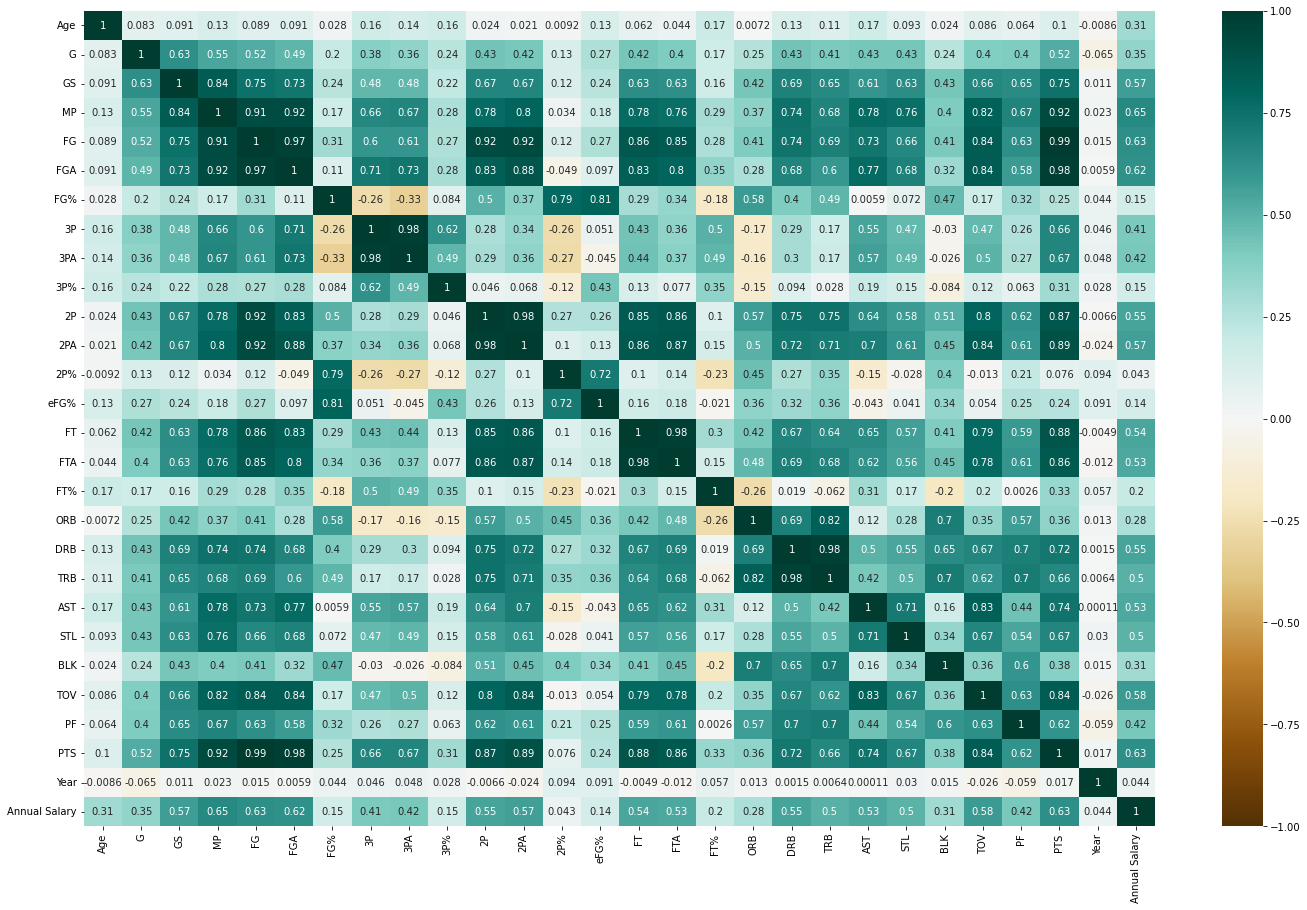

In [47]:
cluster_corr = stat.corr(method = 'spearman') 
## Correlation matrix
figure = plt.figure(figsize = (24,15)) 
sns.heatmap(cluster_corr, annot=True, fmt = '.2g',vmin=-1, vmax=1, cmap='BrBG')

In [48]:
stat.drop('2P', axis = 1, inplace = True) # remove 2 point attempts
stat.drop('3P', axis = 1, inplace = True) # remove 3 point attempts
stat.drop('FG', axis = 1, inplace = True) # remove Field Goal attempts
stat.drop('FT', axis = 1, inplace = True) # remove FT attempts
stat

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Annual Salary
0,1,Álex Abrines,Guard,25,OKC,31.0,2.0,19.0,5.1,0.357,...,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,5455236.0
2,3,Jaylen Adams,Guard,22,ATL,34.0,1.0,12.6,3.2,0.345,...,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2,2019,270014.0
3,4,Steven Adams,Center,25,OKC,80.0,80.0,33.4,10.1,0.595,...,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9,2019,24157303.0
4,5,Bam Adebayo,Center,21,MIA,82.0,28.0,23.3,5.9,0.576,...,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9,2019,2955840.0
7,8,LaMarcus Aldridge,Center,33,SAS,81.0,81.0,33.2,16.3,0.519,...,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3,2019,22347015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,597,Delon Wright,Guard,29,ATL,77.0,8.0,18.9,3.5,0.454,...,2.2,2.9,2.4,1.2,0.2,0.6,0.7,4.4,2022,8526316.0
2976,601,Thaddeus Young,Forward,33,TOT,52.0,1.0,16.3,5.2,0.518,...,2.5,4.0,2.0,1.0,0.3,1.0,1.6,6.2,2022,14190000.0
2979,602,Trae Young,Guard,23,ATL,76.0,76.0,34.9,20.3,0.460,...,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,2022,8326471.0
2980,603,Omer Yurtseven,Center,23,MIA,56.0,12.0,12.6,4.4,0.526,...,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3,2022,1489065.0


In [49]:
stat['Annual Salary'] = stat['Annual Salary'] / 1000

<AxesSubplot:xlabel='Age', ylabel='Count'>

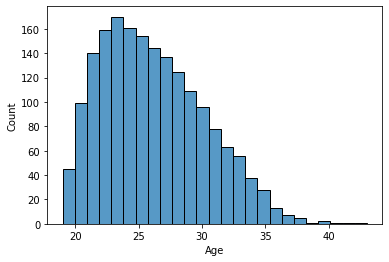

In [50]:
sns.histplot(data = stat['Age'])

<AxesSubplot:xlabel='Age', ylabel='Annual Salary'>

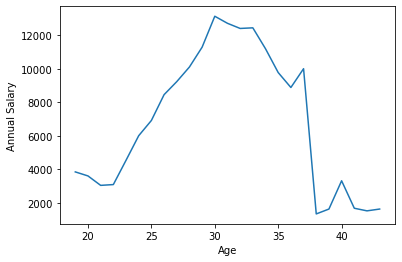

In [51]:
sns.lineplot(data = stat.groupby('Age')['Annual Salary'].mean())

[Text(0.5, 1.0, 'Average NBA player salary by age per season')]

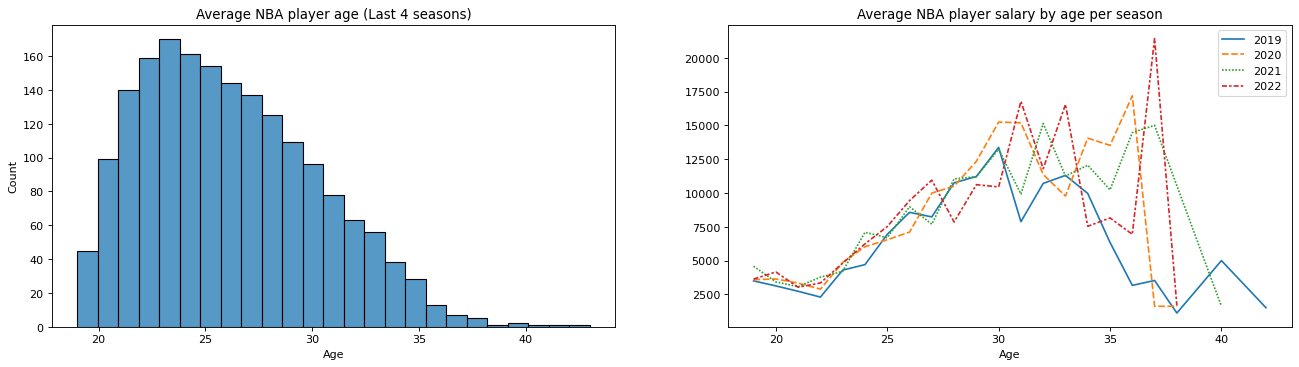

In [52]:
AgeSal = pd.DataFrame({'2019' :  stat[stat['Year']== 2019].groupby('Age')['Annual Salary'].mean()}
                     )
for i in [2020,2021,2022]:
    AgeSal[i] = pd.DataFrame({'i' :  stat[stat['Year']== i].groupby('Age')['Annual Salary'].mean()})
    
fig, axs = plt.subplots(ncols = 2, figsize = (20,5), dpi = 80)
sns.histplot(data = stat['Age'], ax = axs[0]).set(title = 'Average NBA player age (Last 4 seasons)')
sns.lineplot(data = AgeSal, ax= axs[1]).set(title = 'Average NBA player salary by age per season')

[Text(0.5, 1.0, 'Median Annual Salary by position')]

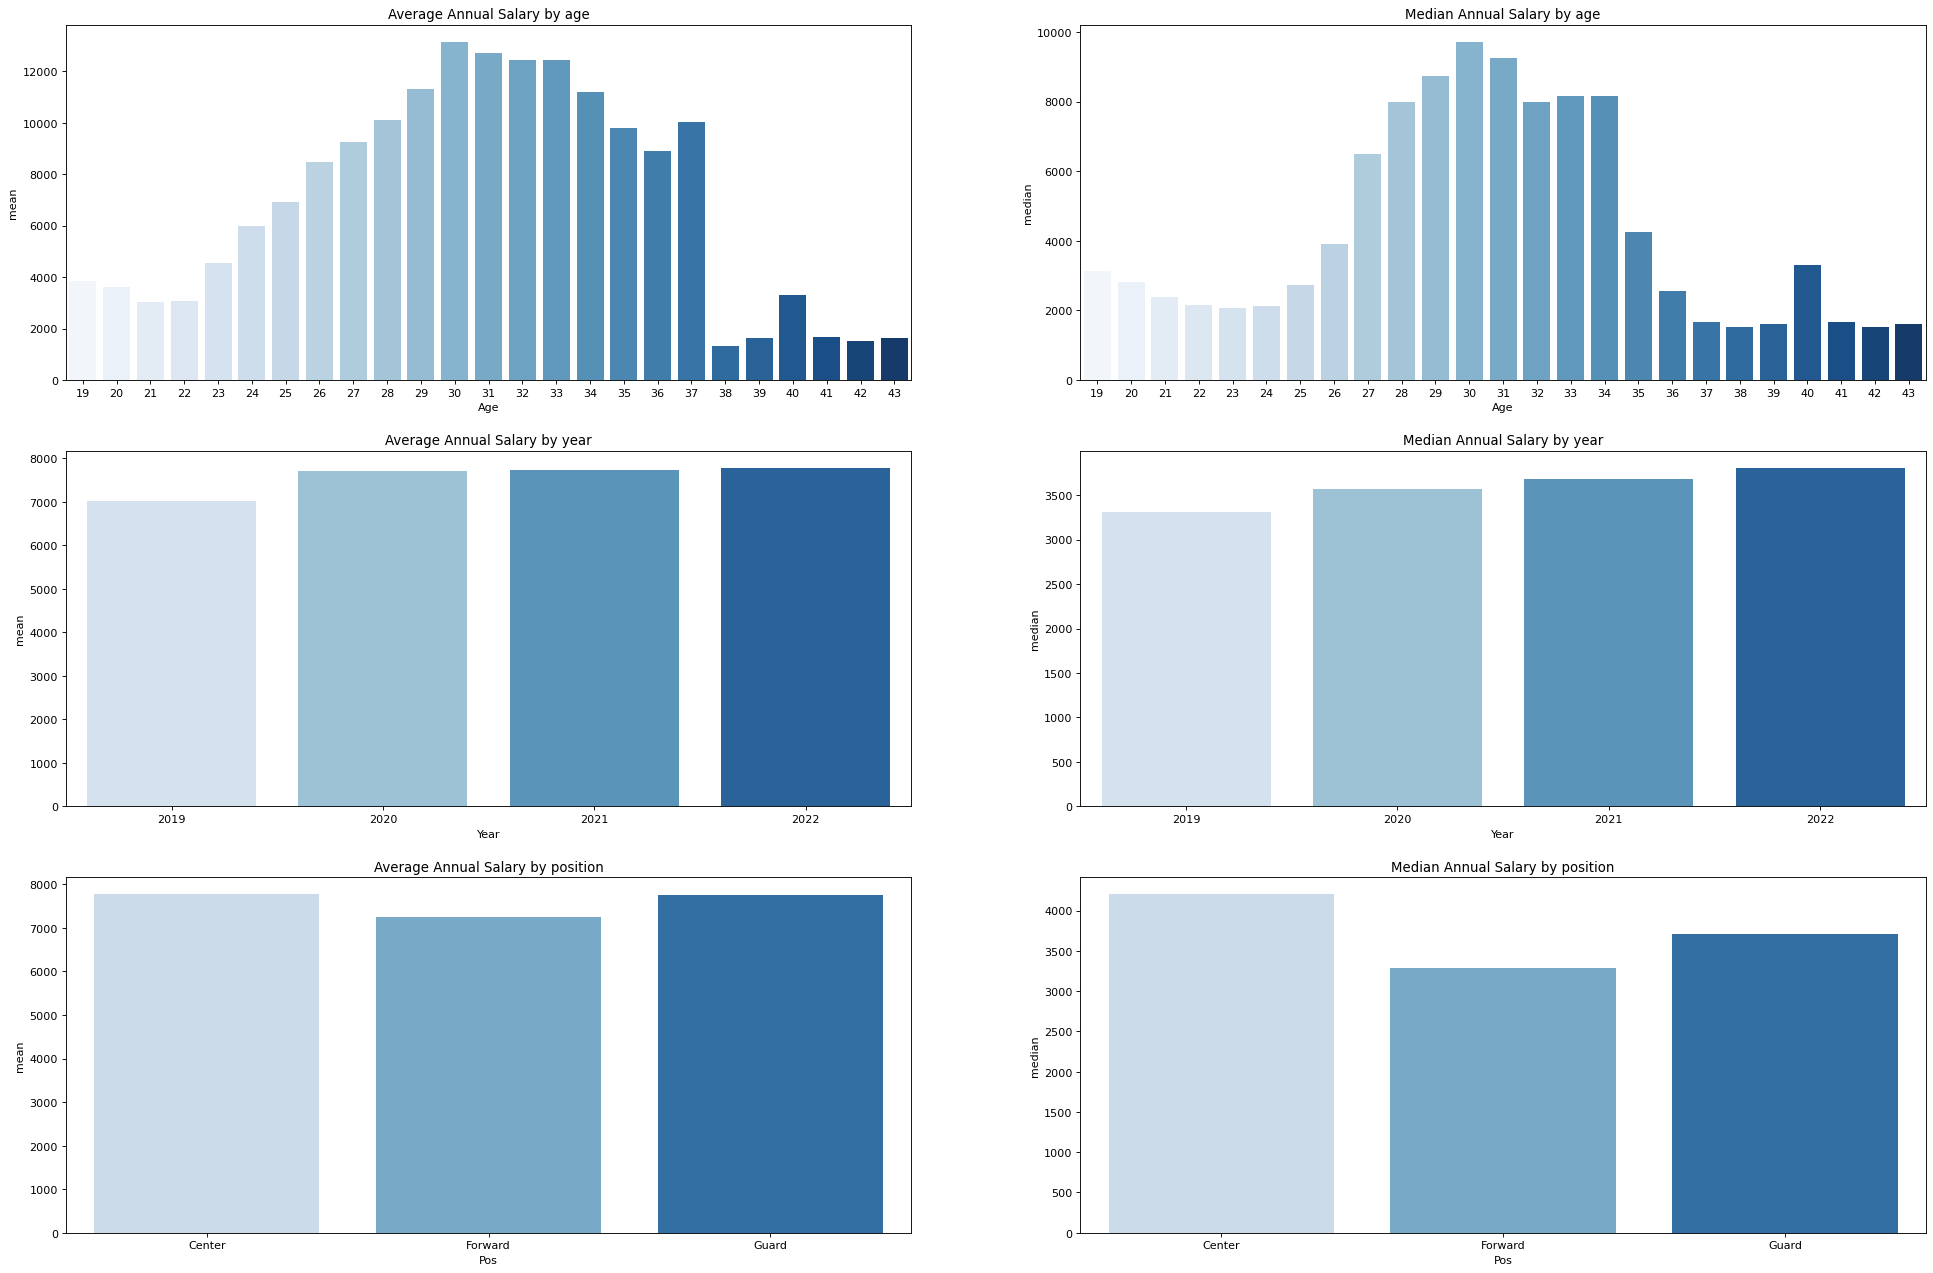

In [53]:
a = pd.DataFrame({'mean':stat.groupby('Year')['Annual Salary'].mean()}).reset_index()
b = pd.DataFrame({'median':stat.groupby('Year')['Annual Salary'].median()}).reset_index()
c = pd.DataFrame({'mean':stat.groupby('Age')['Annual Salary'].mean()}).reset_index()
d = pd.DataFrame({'median':stat.groupby('Age')['Annual Salary'].median() }).reset_index()
e = pd.DataFrame({'mean':stat.groupby('Pos')['Annual Salary'].mean()}).reset_index()
f = pd.DataFrame({'median':stat.groupby('Pos')['Annual Salary'].median()}).reset_index()

fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (30,20), dpi = 80)
sns.barplot( x = a['Year'], y = a['mean']  , ax = axs[1,0], palette="Blues").set(title = 'Average Annual Salary by year')
sns.barplot( x = b['Year'], y = b['median'], ax = axs[1,1], palette="Blues").set(title = 'Median Annual Salary by year')
sns.barplot( x = c['Age'] , y = c['mean']  , ax = axs[0,0], palette="Blues").set(title = 'Average Annual Salary by age')
sns.barplot( x = d['Age'] , y = d['median'], ax = axs[0,1], palette="Blues").set(title = 'Median Annual Salary by age')
sns.barplot( x = e['Pos'] , y = e['mean'], ax = axs[2,0], palette="Blues").set(title = 'Average Annual Salary by position')
sns.barplot( x = f['Pos'] , y = f['median'], ax = axs[2,1], palette="Blues").set(title = 'Median Annual Salary by position')

In [54]:
TmSal = pd.DataFrame({'mean':round(stat.groupby('Tm')['Annual Salary'].mean(),2)})
TmSal['sum'] = pd.DataFrame({'mean':round(stat.groupby('Tm')['Annual Salary'].sum(),2)})

TmSal.sort_values(by='mean', ascending = False, inplace = True)
TmSal.reset_index(inplace=True)

In [55]:
print(' Mean:' ,round(TmSal['mean'].mean(),2), '\n', 'Median:',round(TmSal['mean'].median(),2) )

 Mean: 7746.98 
 Median: 7579.08


[Text(0.5, 1.0, 'Average Salary per NBA Team')]

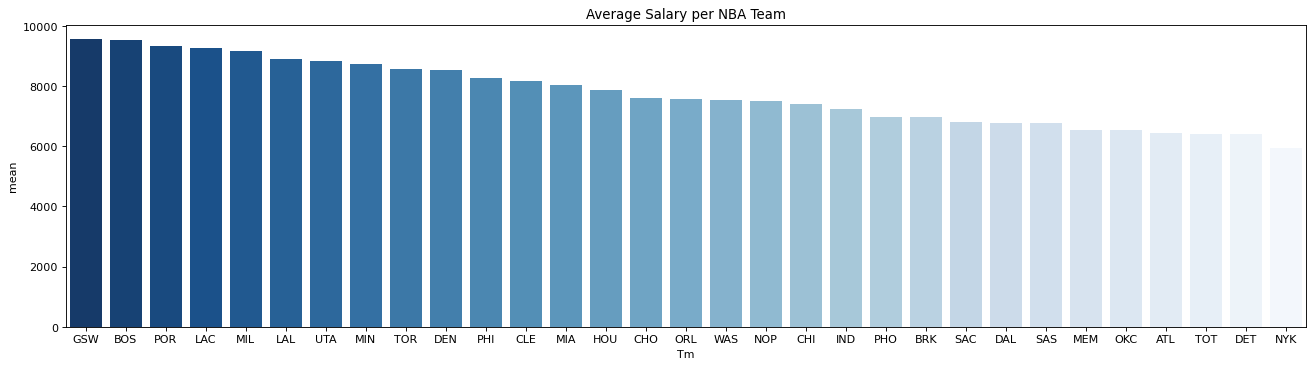

In [56]:
fig, axs = plt.subplots( figsize = (20,5), dpi = 80)
sns.barplot(x=TmSal['Tm'], y= TmSal['mean'], palette = 'Blues_r').set(title = 'Average Salary per NBA Team')

In [57]:
stat[stat['Year'] == 2022].sort_values('PTS', ascending = False)['Player_x'].head(10)

2355              Joel Embiid
2522             LeBron James
2154    Giannis Antetokounmpo
2346             Kevin Durant
2979               Trae Young
2326              Luka Dončić
2314            DeMar DeRozan
2686                Ja Morant
2510             Kyrie Irving
2546             Nikola Jokić
Name: Player_x, dtype: object

<a id='regression'></a>

### 3. Regression Analysis

In [58]:
stat['Salary'] = stat['Annual Salary']
stat['FGeff'] = stat['eFG%']
stat['Perc_3PT'] = stat['3P%']
stat['Perc_2PT'] = stat['2P%']
stat['Perc_FT'] = stat['FT%']
stat['Salary'].round(decimals = 0)
stat.drop('Annual Salary', axis = 1, inplace = True)
stat.drop('3P%', axis = 1, inplace = True)
stat.drop('2P%', axis = 1, inplace = True)
stat.drop('FT%', axis = 1, inplace = True)
stat.drop('eFG%', axis = 1, inplace = True)
stat

,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FGA,FG%,...,BLK,TOV,PF,PTS,Year,Salary,FGeff,Perc_3PT,Perc_2PT,Perc_FT
0,1,Álex Abrines,Guard,25,OKC,31.0,2.0,19.0,5.1,0.357,...,0.2,0.5,1.7,5.3,2019,5455.236,0.487,0.323,0.500,0.923
2,3,Jaylen Adams,Guard,22,ATL,34.0,1.0,12.6,3.2,0.345,...,0.1,0.8,1.3,3.2,2019,270.014,0.459,0.338,0.361,0.778
3,4,Steven Adams,Center,25,OKC,80.0,80.0,33.4,10.1,0.595,...,1.0,1.7,2.6,13.9,2019,24157.303,0.595,0.000,0.596,0.500
4,5,Bam Adebayo,Center,21,MIA,82.0,28.0,23.3,5.9,0.576,...,0.8,1.5,2.5,8.9,2019,2955.840,0.579,0.200,0.588,0.735
7,8,LaMarcus Aldridge,Center,33,SAS,81.0,81.0,33.2,16.3,0.519,...,1.3,1.8,2.2,21.3,2019,22347.015,0.522,0.238,0.528,0.847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,597,Delon Wright,Guard,29,ATL,77.0,8.0,18.9,3.5,0.454,...,0.2,0.6,0.7,4.4,2022,8526.316,0.535,0.379,0.510,0.857
2976,601,Thaddeus Young,Forward,33,TOT,52.0,1.0,16.3,5.2,0.518,...,0.3,1.0,1.6,6.2,2022,14190.000,0.550,0.354,0.554,0.469
2979,602,Trae Young,Guard,23,ATL,76.0,76.0,34.9,20.3,0.460,...,0.1,4.0,1.7,28.4,2022,8326.471,0.536,0.382,0.512,0.904
2980,603,Omer Yurtseven,Center,23,MIA,56.0,12.0,12.6,4.4,0.526,...,0.4,0.7,1.5,5.3,2022,1489.065,0.528,0.091,0.547,0.623


In [59]:
stat.columns

Index(['Rk', 'Player_x', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FGA', 'FG%',
       '3PA', '2PA', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'Year', 'Salary', 'FGeff', 'Perc_3PT', 'Perc_2PT',
       'Perc_FT'],
      dtype='object')

In [60]:
scaler = MinMaxScaler()
stat_regression = stat[['Age', 'PTS', 'G', 'MP', 'FGA', '3PA', '2PA', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'Salary', 'FGeff', 'Perc_3PT', 'Perc_2PT', 'Perc_FT']].copy()
stat_scaled = (scaler.fit_transform(stat_regression))
stat_scaled

array([[0.25      , 0.1468144 , 0.37037037, ..., 0.323     , 0.5       ,
        0.923     ],
       [0.125     , 0.08864266, 0.40740741, ..., 0.338     , 0.361     ,
        0.778     ],
       [0.25      , 0.38504155, 0.97530864, ..., 0.        , 0.596     ,
        0.5       ],
       ...,
       [0.16666667, 0.7867036 , 0.92592593, ..., 0.382     , 0.512     ,
        0.904     ],
       [0.16666667, 0.1468144 , 0.67901235, ..., 0.091     , 0.547     ,
        0.623     ],
       [0.20833333, 0.28531856, 0.92592593, ...,        nan, 0.626     ,
        0.727     ]])

In [61]:
stat_regression_columns = stat_regression.columns
stat_regression = pd.DataFrame(stat_scaled, columns = stat_regression_columns)
stat_regression.rename(columns = {'3PA':'PA3', '2PA':'PA2'}, inplace = True)
stat_regression

,Age,PTS,G,MP,FGA,PA3,PA2,FTA,ORB,DRB,...,AST,STL,BLK,TOV,PF,Salary,FGeff,Perc_3PT,Perc_2PT,Perc_FT
0,0.250000,0.146814,0.370370,0.487805,0.208163,0.310606,0.053476,0.033898,0.037037,0.122807,...,0.051282,0.227273,0.058824,0.10,0.346939,0.119068,0.487,0.323,0.500,0.923
1,0.125000,0.088643,0.407407,0.314363,0.130612,0.166667,0.058824,0.025424,0.055556,0.122807,...,0.162393,0.181818,0.029412,0.16,0.265306,0.005795,0.459,0.338,0.361,0.778
2,0.250000,0.385042,0.975309,0.878049,0.412245,0.000000,0.540107,0.313559,0.907407,0.403509,...,0.136752,0.681818,0.294118,0.34,0.530612,0.527622,0.595,0.000,0.596,0.500
3,0.083333,0.246537,1.000000,0.604336,0.240816,0.015152,0.304813,0.237288,0.370370,0.464912,...,0.188034,0.409091,0.235294,0.30,0.510204,0.064468,0.579,0.200,0.588,0.735
4,0.583333,0.590028,0.987654,0.872629,0.665306,0.037879,0.844920,0.432203,0.574074,0.535088,...,0.205128,0.227273,0.382353,0.36,0.448980,0.488076,0.522,0.238,0.528,0.847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828,0.416667,0.121884,0.938272,0.485095,0.142857,0.113636,0.106952,0.067797,0.111111,0.192982,...,0.205128,0.545455,0.058824,0.12,0.142857,0.186157,0.535,0.379,0.510,0.857
1829,0.583333,0.171745,0.629630,0.414634,0.212245,0.068182,0.229947,0.076271,0.277778,0.219298,...,0.170940,0.454545,0.088235,0.20,0.326531,0.309883,0.550,0.354,0.554,0.469
1830,0.166667,0.786704,0.925926,0.918699,0.828571,0.606061,0.657754,0.618644,0.129630,0.271930,...,0.829060,0.409091,0.029412,0.80,0.346939,0.181792,0.536,0.382,0.512,0.904
1831,0.166667,0.146814,0.679012,0.314363,0.179592,0.015152,0.224599,0.093220,0.277778,0.324561,...,0.076923,0.136364,0.117647,0.14,0.306122,0.032426,0.528,0.091,0.547,0.623


In [62]:
import statsmodels.formula.api as smf

results = smf.ols('Salary ~ Age + PTS + G + AST + BLK + TRB + STL + PF', data = stat_regression).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     322.2
Date:                Mon, 23 May 2022   Prob (F-statistic):               0.00
Time:                        00:06:07   Log-Likelihood:                 1204.5
No. Observations:                1833   AIC:                            -2391.
Df Residuals:                    1824   BIC:                            -2341.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0805      0.010     -8.011      0.0

In [63]:
results = smf.ols('Salary ~ Age + PTS + G + AST + BLK + TRB + STL + PF', data = stat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     322.2
Date:                Mon, 23 May 2022   Prob (F-statistic):               0.00
Time:                        00:06:07   Log-Likelihood:                -18466.
No. Observations:                1833   AIC:                         3.695e+04
Df Residuals:                    1824   BIC:                         3.700e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.429e+04    906.120    -15.771      0.0

<a id='cluster'></a>

### 4. Clustering

In [64]:
stat.columns

Index(['Rk', 'Player_x', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FGA', 'FG%',
       '3PA', '2PA', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'Year', 'Salary', 'FGeff', 'Perc_3PT', 'Perc_2PT',
       'Perc_FT'],
      dtype='object')

In [65]:
cluster_off = stat[['PTS', 'AST', 'ORB', 'TOV']].copy()
cluster_def = stat[['STL', 'BLK', 'DRB']].copy()
cluster_def

,STL,BLK,DRB
0,0.5,0.2,1.4
2,0.4,0.1,1.4
3,1.5,1.0,4.6
4,0.9,0.8,5.3
7,0.5,1.3,6.1
...,...,...,...
2969,1.2,0.2,2.2
2976,1.0,0.3,2.5
2979,0.9,0.1,3.1
2980,0.3,0.4,3.7


<a id='scaling'></a>

### 4.1 Data Scaling

In [66]:
scaler = MinMaxScaler()
cluster_off_scaled = (scaler.fit(cluster_off)) 
cluster_off_scaled = (scaler.transform(cluster_off))

#Min max scaler was used to scale all variables to perform clustering

In [67]:
cluster_def_scaled = (scaler.fit(cluster_def))
cluster_def_scaled = (scaler.transform(cluster_def))

In [68]:
cols_off = cluster_off.columns
offensive_cluster = pd.DataFrame(cluster_off_scaled, columns = cols_off)
cols_def = cluster_def.columns
defensive_cluster = pd.DataFrame(cluster_def_scaled, columns = cols_def)

In [69]:
offensive_cluster

,PTS,AST,ORB,TOV
0,0.146814,0.051282,0.037037,0.10
1,0.088643,0.162393,0.055556,0.16
2,0.385042,0.136752,0.907407,0.34
3,0.246537,0.188034,0.370370,0.30
4,0.590028,0.205128,0.574074,0.36
...,...,...,...,...
1828,0.121884,0.205128,0.111111,0.12
1829,0.171745,0.170940,0.277778,0.20
1830,0.786704,0.829060,0.129630,0.80
1831,0.146814,0.076923,0.277778,0.14


In [70]:
defensive_cluster

,STL,BLK,DRB
0,0.227273,0.058824,0.122807
1,0.181818,0.029412,0.122807
2,0.681818,0.294118,0.403509
3,0.409091,0.235294,0.464912
4,0.227273,0.382353,0.535088
...,...,...,...
1828,0.545455,0.058824,0.192982
1829,0.454545,0.088235,0.219298
1830,0.409091,0.029412,0.271930
1831,0.136364,0.117647,0.324561


<a id='offensive'></a>

### 4.2 Offensive Cluster

In [71]:
from sklearn.cluster import KMeans

ks = range(1, 11) # loop between 1 and 10
inertias = [] # also called sum of squared errors (difference between the points of the data and the centroid)

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(offensive_cluster)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

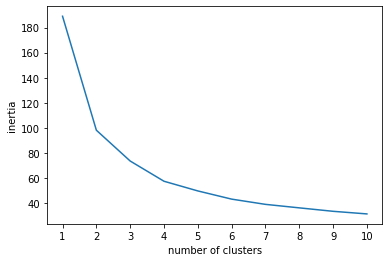

In [72]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot(). 
plt.plot(ks, inertias)

# define the label for x axis as 'number of clusters' using matplotlib.pyplot.xlabel
plt.xlabel('number of clusters')
# define the label for y axis as 'inertia' using matplotlib.pyplot.ylabel
plt.ylabel('inertia')
# define the ticks in x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.show()

In [73]:
offensive_k2 = KMeans(n_clusters = 2, random_state = 0)

In [74]:
offensive_cluster_copy = offensive_cluster.copy()
offensive_k2.fit(offensive_cluster)

KMeans(n_clusters=2, random_state=0)

In [75]:
offensive_cluster['Cluster_off'] = offensive_k2.labels_
offensive_cluster

,PTS,AST,ORB,TOV,Cluster_off
0,0.146814,0.051282,0.037037,0.10,0
1,0.088643,0.162393,0.055556,0.16,0
2,0.385042,0.136752,0.907407,0.34,1
3,0.246537,0.188034,0.370370,0.30,0
4,0.590028,0.205128,0.574074,0.36,1
...,...,...,...,...,...
1828,0.121884,0.205128,0.111111,0.12,0
1829,0.171745,0.170940,0.277778,0.20,0
1830,0.786704,0.829060,0.129630,0.80,1
1831,0.146814,0.076923,0.277778,0.14,0


In [76]:
offensive_cluster.groupby(['Cluster_off']).describe().transpose()

Cluster_off            0           1
PTS count    1384.000000  449.000000
    mean        0.192074    0.503551
    std         0.097677    0.148642
    min         0.000000    0.000000
    25%         0.119114    0.404432
    50%         0.182825    0.487535
    75%         0.254848    0.587258
    max         0.554017    1.000000
AST count    1384.000000  449.000000
    mean        0.117101    0.386557
    std         0.077120    0.174196
    min         0.000000    0.068376
    25%         0.059829    0.247863
    50%         0.102564    0.367521
    75%         0.162393    0.495726
    max         0.427350    1.000000
ORB count    1384.000000  449.000000
    mean        0.149941    0.222882
    std         0.123503    0.174939
    min         0.000000    0.037037
    25%         0.055556    0.111111
    50%         0.111111    0.166667
    75%         0.203704    0.277778
    max         0.759259    1.000000
TOV count    1384.000000  449.000000
    mean        0.163642    0.468552
    std         0.077994    0.149505
    min         0.000000    0.240000
    25%         0.100000    0.360000
    50%         0.160000    0.440000
    75%         0.220000    0.560000
    max         0.440000    1.000000

<a id='defensive'></a>

### 4.3 Defensive Cluster

In [77]:
ks = range(1, 11) # loop between 1 and 10
inertias = [] # also called sum of squared errors (difference between the points of the data and the centroid)

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(defensive_cluster)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

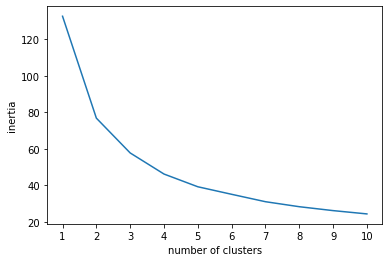

In [78]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot(). 
plt.plot(ks, inertias)

# define the label for x axis as 'number of clusters' using matplotlib.pyplot.xlabel
plt.xlabel('number of clusters')
# define the label for y axis as 'inertia' using matplotlib.pyplot.ylabel
plt.ylabel('inertia')
# define the ticks in x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.show()

In [79]:
defensive_k2 = KMeans(n_clusters = 2, random_state = 0)

In [80]:
defensive_cluster_copy = defensive_cluster.copy()
defensive_k2.fit(defensive_cluster)

KMeans(n_clusters=2, random_state=0)

In [81]:
defensive_cluster['Cluster_def'] = defensive_k2.labels_
defensive_cluster

,STL,BLK,DRB,Cluster_def
0,0.227273,0.058824,0.122807,0
1,0.181818,0.029412,0.122807,0
2,0.681818,0.294118,0.403509,1
3,0.409091,0.235294,0.464912,1
4,0.227273,0.382353,0.535088,1
...,...,...,...,...
1828,0.545455,0.058824,0.192982,1
1829,0.454545,0.088235,0.219298,1
1830,0.409091,0.029412,0.271930,1
1831,0.136364,0.117647,0.324561,0


In [82]:
defensive_cluster.groupby(['Cluster_def']).describe().transpose()

Cluster_def            0           1
STL count    1138.000000  695.000000
    mean        0.206463    0.467299
    std         0.105753    0.154523
    min         0.000000    0.136364
    25%         0.136364    0.363636
    50%         0.227273    0.454545
    75%         0.272727    0.545455
    max         0.500000    1.000000
BLK count    1138.000000  695.000000
    mean        0.084901    0.199873
    std         0.074282    0.144023
    min         0.000000    0.000000
    25%         0.029412    0.117647
    50%         0.058824    0.147059
    75%         0.117647    0.264706
    max         0.411765    1.000000
DRB count    1138.000000  695.000000
    mean        0.184773    0.404443
    std         0.086780    0.162197
    min         0.000000    0.070175
    25%         0.122807    0.289474
    50%         0.175439    0.359649
    75%         0.245614    0.486842
    max         0.438596    1.000000

In [83]:
defensive_cluster.isna().sum()

STL            0
BLK            0
DRB            0
Cluster_def    0
dtype: int64

<a id='combine'></a>

### 4.4 Combine Clusters

In [84]:
#Add both clusters into the main DataFrame
stat.reset_index(inplace = True)
stat['Cluster_off'] = offensive_cluster['Cluster_off'].astype(str)
stat['Cluster_def'] = defensive_cluster['Cluster_def'].astype(str)

In [85]:
#Creating the combine clusters
stat['Clusters'] = offensive_cluster['Cluster_off'].astype(str) + defensive_cluster['Cluster_def'].astype(str)
stat

,index,Rk,Player_x,Pos,Age,Tm,G,GS,MP,FGA,...,PTS,Year,Salary,FGeff,Perc_3PT,Perc_2PT,Perc_FT,Cluster_off,Cluster_def,Clusters
0,0,1,Álex Abrines,Guard,25,OKC,31.0,2.0,19.0,5.1,...,5.3,2019,5455.236,0.487,0.323,0.500,0.923,0,0,00
1,2,3,Jaylen Adams,Guard,22,ATL,34.0,1.0,12.6,3.2,...,3.2,2019,270.014,0.459,0.338,0.361,0.778,0,0,00
2,3,4,Steven Adams,Center,25,OKC,80.0,80.0,33.4,10.1,...,13.9,2019,24157.303,0.595,0.000,0.596,0.500,1,1,11
3,4,5,Bam Adebayo,Center,21,MIA,82.0,28.0,23.3,5.9,...,8.9,2019,2955.840,0.579,0.200,0.588,0.735,0,1,01
4,7,8,LaMarcus Aldridge,Center,33,SAS,81.0,81.0,33.2,16.3,...,21.3,2019,22347.015,0.522,0.238,0.528,0.847,1,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828,2969,597,Delon Wright,Guard,29,ATL,77.0,8.0,18.9,3.5,...,4.4,2022,8526.316,0.535,0.379,0.510,0.857,0,1,01
1829,2976,601,Thaddeus Young,Forward,33,TOT,52.0,1.0,16.3,5.2,...,6.2,2022,14190.000,0.550,0.354,0.554,0.469,0,1,01
1830,2979,602,Trae Young,Guard,23,ATL,76.0,76.0,34.9,20.3,...,28.4,2022,8326.471,0.536,0.382,0.512,0.904,1,1,11
1831,2980,603,Omer Yurtseven,Center,23,MIA,56.0,12.0,12.6,4.4,...,5.3,2022,1489.065,0.528,0.091,0.547,0.623,0,0,00


In [86]:
round(stat.groupby('Clusters').mean(),2)

,index,Age,G,GS,MP,FGA,FG%,3PA,2PA,FTA,...,BLK,TOV,PF,PTS,Year,Salary,FGeff,Perc_3PT,Perc_2PT,Perc_FT
Clusters,,,,,,,,,,,,,,,,,,,,,
00,1439.57,25.71,44.14,10.45,15.93,5.05,0.44,2.20,2.85,1.09,...,0.29,0.72,1.47,6.04,2020.49,3685.78,0.51,0.31,0.51,0.74
01,1447.58,26.24,58.50,33.85,24.98,7.82,0.48,2.95,4.87,1.90,...,0.72,1.12,2.25,9.86,2020.53,7494.01,0.55,0.32,0.55,0.73
10,1468.68,26.87,56.94,38.13,28.96,12.91,0.43,5.24,7.66,3.21,...,0.24,2.10,1.97,15.90,2020.53,10299.92,0.51,0.36,0.49,0.83
11,1459.02,26.26,60.44,55.43,31.93,14.44,0.47,4.73,9.72,4.23,...,0.64,2.39,2.39,18.66,2020.54,18123.29,0.53,0.34,0.52,0.79


In [87]:
stat[stat['Clusters'] == '11']['Player_x'].value_counts().tail(50)

Zion Williamson            1
Jalen Suggs                1
Josh Giddey                1
Cole Anthony               1
Desmond Bane               1
Alperen Şengün             1
Kevin Porter Jr.           1
Scottie Barnes             1
Théo Maledon               1
Miles Bridges              1
Jakob Poeltl               1
Wendell Carter Jr.         1
Evan Mobley                1
Cade Cunningham            1
Tyler Herro                1
Luguentz Dort              1
Saddiq Bey                 1
Enes Freedom               1
Killian Hayes              1
Darren Collison            1
Carmelo Anthony            1
Dwyane Wade                1
Bruce Brown                1
Klay Thompson              1
Alec Burks                 1
Jeff Teague                1
Dennis Smith Jr.           1
Devonte' Graham            1
Rajon Rondo                1
Kevin Huerter              1
Serge Ibaka                1
Lauri Markkanen            1
Marcus Morris              1
Shabazz Napier             1
Kelly Oubre Jr

<a id='viz'></a>

### 4.5 Clusters' Data Visualization

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Points and Assists by cluster')]

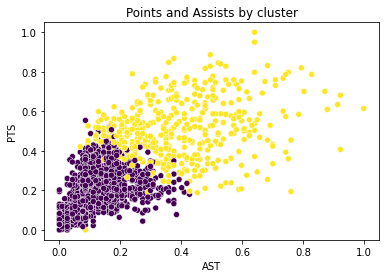

In [88]:
xs_off = offensive_cluster.iloc[:,1] #assists
ys_off = offensive_cluster.iloc[:,0] #points
zs_off = offensive_cluster.iloc[:,4] #cluster
sns.scatterplot(xs_off,ys_off, c = zs_off).set(title = 'Points and Assists by cluster')

In [89]:
graph_off = stat[['PTS', 'AST', 'ORB', 'TOV', 'Cluster_off']].copy()
graph_off['Offensive cluster'] = graph_off['Cluster_off']

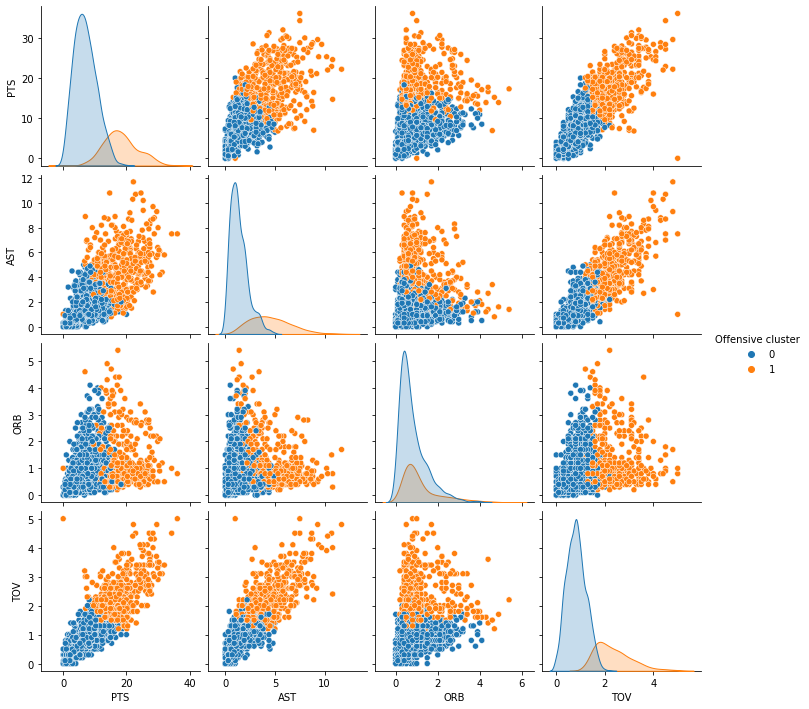

In [90]:
sns.pairplot(graph_off, hue = 'Offensive cluster', kind = 'scatter')

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Blocks and Steals by cluster')]

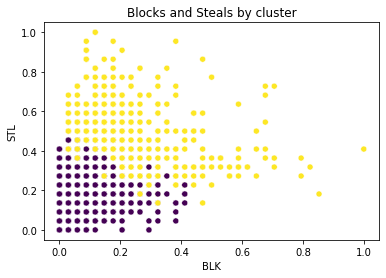

In [91]:
xs_def = defensive_cluster.iloc[:,1] #Blocks
ys_def = defensive_cluster.iloc[:,0] #Steals
zs_def = defensive_cluster.iloc[:,3] #cluster
sns.scatterplot(xs_def,ys_def, c = zs_def).set(title = 'Blocks and Steals by cluster')

In [92]:
graph_def = stat[['STL', 'BLK', 'DRB', 'Cluster_def']].copy()
graph_def['Defensive cluster'] = graph_def['Cluster_def']

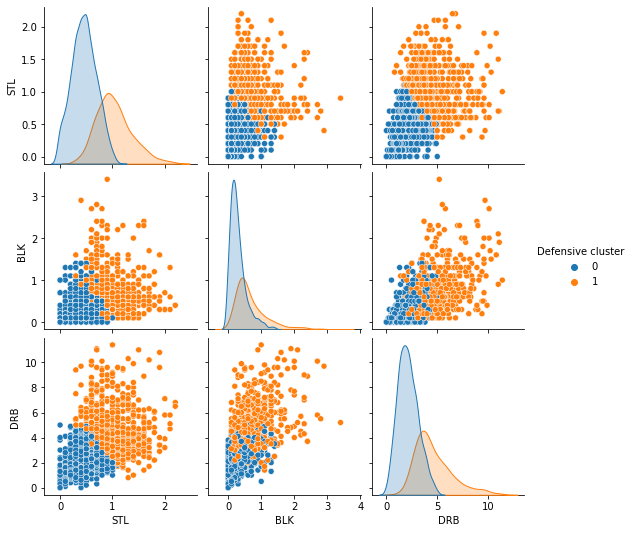

In [93]:
sns.pairplot(graph_def, hue = 'Defensive cluster', kind = 'scatter'  )

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Salary dispersion per Points and Assists')]

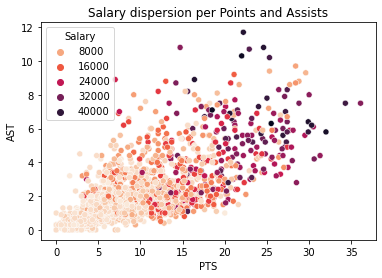

In [94]:
xs = stat.iloc[:,22] # points
ys = stat.iloc[:,17] # Assists
zs = stat.iloc[:,24] # Salary
sns.scatterplot(xs,ys, hue = zs, palette = 'rocket_r', legend = 'brief').set(title = 'Salary dispersion per Points and Assists')


In [95]:
round(stat[['PTS','AST','DRB','TOV', 'STL', 'BLK', 'ORB', 'Salary']].groupby(stat['Clusters']).mean(),2)

,PTS,AST,DRB,TOV,STL,BLK,ORB,Salary
Clusters,,,,,,,,
00,6.04,1.22,2.06,0.72,0.44,0.29,0.65,3685.78
01,9.86,1.86,3.99,1.12,0.94,0.72,1.32,7494.01
10,15.90,4.04,2.74,2.10,0.67,0.24,0.61,10299.92
11,18.66,4.62,5.15,2.39,1.10,0.64,1.33,18123.29


In [96]:
stat['Clusters'].value_counts()

00    1060
11     371
01     324
10      78
Name: Clusters, dtype: int64

In [97]:
stat.columns

Index(['index', 'Rk', 'Player_x', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FGA',
       'FG%', '3PA', '2PA', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Year', 'Salary', 'FGeff', 'Perc_3PT', 'Perc_2PT',
       'Perc_FT', 'Cluster_off', 'Cluster_def', 'Clusters'],
      dtype='object')

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Salary dispersion per Steals and Blocks')]

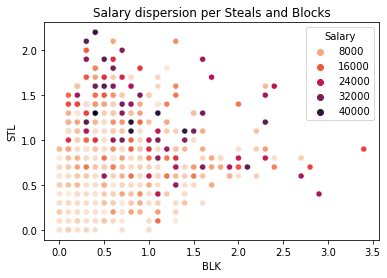

In [98]:
xs_ = stat.iloc[:,19] # Blocks
ys_ = stat.iloc[:,18] # Steals
zs_ = stat.iloc[:,24] # Salary
sns.scatterplot(xs_,ys_, hue = zs_, palette = 'rocket_r', legend = 'brief').set(title = 'Salary dispersion per Steals and Blocks')

In [99]:
stat[['Player_x', 'Pos', 'Clusters']].groupby('Clusters').describe(include=['O']).transpose()

Clusters                 00                01             10              11
Player_x count         1060               324             78             371
         unique         547               191             57             164
         top     Trey Burke  Robert Covington  Collin Sexton  Andrew Wiggins
         freq             4                 4              4               4
Pos      count         1060               324             78             371
         unique           3                 3              3               3
         top        Forward           Forward          Guard           Guard
         freq           433               156             69             179